In [1]:
import torch
import numpy as np
from cryodrgn.source import ImageSource
import os
import pickle
import torch

dat = torch.load("../train_projections.pt")
ids = dat['ids']
images = dat['images']
phis = dat['phis']
thetas = dat['thetas']

/tmp/ipykernel_107098/3342283929.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dat = torch.load("../train_projections.pt")


In [2]:

dat_val = torch.load("../val_projections.pt")
ids_val = dat_val['ids']
images_val = dat_val['images']
phis_val = dat_val['phis']
thetas_val = dat_val['thetas']

/tmp/ipykernel_107098/3424032285.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dat_val = torch.load("../val_projections.pt")


In [3]:
import train
model = train.ContrastiveModel().cuda()
model.load_state_dict({k[6:] : v for k,v in torch.load("../cryofinder-training/resnet_v1_20250302_164847/checkpoints/last.ckpt")['state_dict'].items() if k.startswith("model.")})
model.eval()


/state/partition1/llgrid/pkg/anaconda/python-ML-2025a/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/python-ML-2025a/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_107098/1261279626.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release,

ContrastiveModel(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [4]:
images_all_raw = torch.cat([images, images_val]).view((-1,128,128))
images_all = torch.clamp((images_all_raw - images_all_raw.mean(dim=(-1,-2), keepdim=True)) / images_all_raw.std(dim=(-1,-2), keepdim=True), -5, 15)

ids_all = torch.cat([ids, ids_val]).unsqueeze(-1).expand([-1, 192]).reshape((-1,))

print(images_all.shape)
print(ids_all.shape)

torch.Size([723840, 128, 128])
torch.Size([723840])


In [5]:
all_embs = []
bsize = 1000

with torch.no_grad():
    for i in range(0, images_all.shape[0], bsize):
        inputs = images_all[i:i+bsize].unsqueeze(1).cuda()
        emb = model(inputs)
        all_embs.append(emb)
        print(i)
        

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


KeyboardInterrupt: 

In [5]:
all_embs = torch.load("../dataset_embeddings_v1.pt").cuda()

/tmp/ipykernel_107098/806093029.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_embs = torch.load("../dataset_embeddings_v1.pt").cuda()


In [6]:
phis_all = torch.cat([phis, phis_val]).view(-1)
thetas_all = torch.cat([thetas, thetas_val]).view(-1)

In [8]:
import torch.nn.functional as F
all_embs = F.normalize(torch.cat(all_embs), p=2, dim=1)


TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [7]:
print(all_embs.shape)

torch.Size([723840, 128])


In [8]:
query_idxs = torch.tensor([i*192 + x for i,x in enumerate(torch.randint(192, (images_val.shape[0],)))]) + images.shape[0] * images.shape[1]

In [9]:
query_idxs

tensor([672121, 672352, 672450, 672585, 672859, 673031, 673255, 673450, 673602,
        673886, 674091, 674274, 674307, 674665, 674857, 674936, 675126, 675289,
        675527, 675800, 675854, 676123, 676324, 676513, 676707, 676927, 677106,
        677240, 677512, 677688, 677769, 678092, 678234, 678345, 678594, 678771,
        679000, 679271, 679405, 679554, 679731, 679926, 680205, 680297, 680516,
        680765, 680974, 681201, 681221, 681589, 681693, 681865, 682048, 682321,
        682463, 682595, 682800, 683080, 683279, 683500, 683562, 683721, 684046,
        684176, 684313, 684626, 684860, 685039, 685136, 685352, 685602, 685673,
        685867, 686024, 686394, 686435, 686672, 686870, 687142, 687175, 687423,
        687652, 687925, 688107, 688308, 688392, 688629, 688878, 688897, 689277,
        689334, 689602, 689822, 689919, 690147, 690267, 690593, 690692, 690922,
        691180, 691352, 691564, 691697, 691959, 692100, 692303, 692429, 692700,
        692909, 693006, 693301, 693388, 

In [10]:
# rotate, translate, and generally perturb the query images
from data import ContrastiveProjectionDataset 
from torch.utils.data import DataLoader

query_ids = ids_all[query_idxs]


dataset = ContrastiveProjectionDataset(images_all[query_idxs].unsqueeze(1), torch.zeros((*query_idxs.shape,1)), torch.zeros((*query_idxs.shape,1)), query_ids, proj_per_obj=1)
loader = torch.utils.data.DataLoader(dataset, collate_fn=lambda x: ContrastiveProjectionDataset.collate_fn(x, dataset.lat, dataset.mask, dataset.freqs, ctf_corrupt=False, noise=True), shuffle=False, batch_size=10)

(INFO) (lattice.py) (09-Mar-25 19:24:39) Using circular lattice with radius=64


/state/partition1/llgrid/pkg/anaconda/python-ML-2025a/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
import torch.nn.functional as F
import time
query_imgs = torch.cat([batch[0][:,0].unsqueeze(1) for batch in loader])

s = time.time()
with torch.no_grad():
    query_embs = F.normalize(model(query_imgs.cuda()), p=2, dim=-1)
e = time.time()
print(e-s)
print(query_embs.shape)
print(query_ids.shape)

0.273770809173584
torch.Size([270, 128])
torch.Size([270])


In [12]:
# create masks for angular distance
query_thetas = thetas_all[query_idxs].unsqueeze(1)
query_phis = phis_all[query_idxs].unsqueeze(1)

# Calculate angular distances
angle_dists = torch.where(query_ids.unsqueeze(-1) == ids_all, torch.arccos(
    torch.sin(query_thetas) * torch.sin(thetas_all) * torch.cos(query_phis - phis_all) + 
    torch.cos(query_thetas) * torch.cos(thetas_all)
), float('inf')) * 180 / torch.pi

angle_mask = angle_dists > 10

In [13]:
# now generate the outer products
import time

s = start_time = time.time()
affinities = (query_embs @ all_embs.t()).cpu() * angle_mask
e = start_time = time.time()
print(e-s)
print(affinities.shape)

0.327042818069458
torch.Size([270, 723840])


In [14]:
top_affinities, top_indices = torch.topk(affinities, k=65, dim=1)
acc = query_ids.unsqueeze(1) == ids_all[top_indices.cpu()]
acc_cum = acc.cumsum(dim=1)

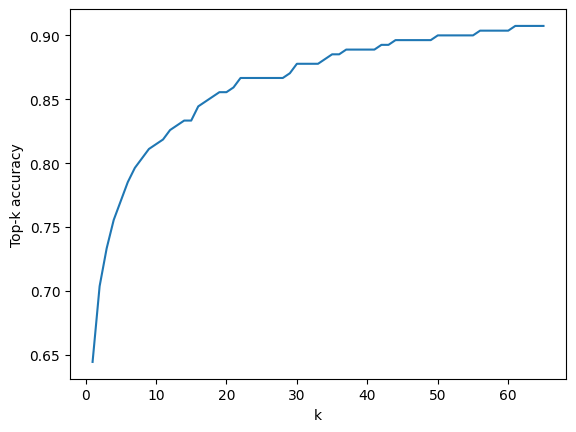

In [15]:
import matplotlib.pyplot as plt
plt.plot(torch.arange(acc.shape[-1]) + 1, (acc_cum > 0).to(torch.float).mean(dim=0))
plt.ylabel("Top-k accuracy")
plt.xlabel("k")
plt.show()

In [16]:
best_idx_tensor = -1*torch.ones(acc.shape, dtype=torch.long)
for i,r in enumerate(ids_all[top_indices[:,1:].cpu()]):
    b,c = torch.unique(r, return_counts=True)
    best_idxs = sorted(zip(c.tolist(), b.tolist()), reverse=True)

    for j, (c, idx) in enumerate(best_idxs):
        best_idx_tensor[i,j] = idx 

best_idx_acc = (best_idx_tensor == query_ids.unsqueeze(1)).to(torch.float).cumsum(dim=1)

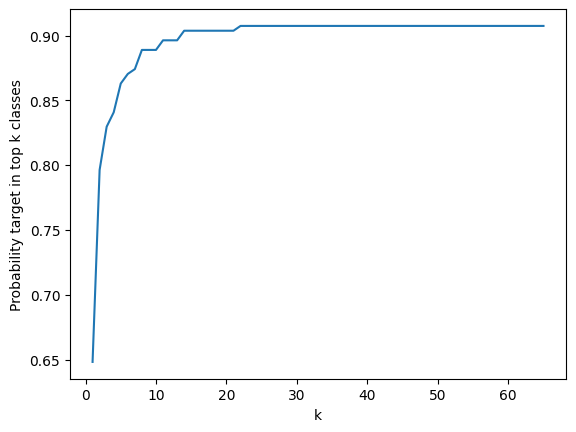

In [17]:
import matplotlib.pyplot as plt
plt.plot(torch.arange(acc.shape[-1]) + 1, best_idx_acc.mean(dim=0))
plt.xlabel("k")
plt.ylabel("Probability target in top k classes")
plt.show()

In [18]:
# now query the val embeddings against the dataset with the classical search

from proj_search import optimize_theta_trans_chunked

from cryodrgn import shift_grid, so3_grid
trans = torch.tensor(shift_grid.base_shift_grid(0, 7, 7, xshift=0, yshift=0))
angles = torch.tensor(so3_grid.grid_s1(2), dtype=torch.float)
s = time.time()
res = []
for i in range(0, query_imgs.shape[0], 5):
    best_corr, best_indices, corr = optimize_theta_trans_chunked((images_all - images_all.mean(dim=(-1,-2),keepdim=True)).view([-1,128,128]), (query_imgs  - query_imgs.mean(dim=(-1,-2), keepdim=True)).view([-1,128,128])[:i+5].cuda(), trans.cuda(), angles, chunk_size=60, fast_translate=False, fast_rotate=True, refine_fast_translate=False)
    res.append((best_corr, best_indices, corr))
    print(i)
e = time.time()


(INFO) (lattice.py) (09-Mar-25 19:24:52) Using circular lattice with radius=64
0
(INFO) (lattice.py) (09-Mar-25 19:41:52) Using circular lattice with radius=64


OutOfMemoryError: CUDA out of memory. Tried to allocate 43.74 GiB. GPU 0 has a total capacity of 31.74 GiB of which 30.59 GiB is free. Including non-PyTorch memory, this process has 1.14 GiB memory in use. Of the allocated memory 677.98 MiB is allocated by PyTorch, and 108.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [19]:
res[0]

(tensor([15030.6875, 16044.4395, 11289.7373, 16076.2012, 14353.6191],
        device='cuda:0'),
 tensor([[456502,     27,     13],
         [672352,     43,     15],
         [672493,      2,     17],
         [672585,     47,      5],
         [672859,     36,     10]], device='cuda:0'),
 tensor([[ 9299.8086,  9709.8408,  9186.9160,  ...,  8117.0791,  7664.0615,
           7606.5874],
         [11673.9141, 12107.0811, 11615.2725,  ..., 10039.8750,  9468.5215,
           9253.9834],
         [ 3889.7659,  3653.7769,  3602.6338,  ...,  3190.3257,  3496.2766,
           3562.9170],
         [ 8412.8945,  8729.5908,  8779.4980,  ...,  7613.7612,  7051.0474,
           7221.5698],
         [11621.0703, 11391.7393, 11170.1611,  ...,  8518.4736,  8200.0156,
           8243.6807]], device='cuda:0'))

In [14]:
imglist.shape

torch.Size([140, 128, 128])

In [6]:
# do some investigating from the val2025 data
from cryodrgn.source import ImageSource
import os
import torch

emds = [x[:-1].lower().replace('-','_') for x in open("../val2025_maps.txt",'r').readlines()]
imglist = []
for i,e in enumerate(emds):
    if os.path.exists('/home/gridsan/jroney/val_2025_dataset/' + e + ".mrcs"):
        imglist.append(ImageSource.from_file('/home/gridsan/jroney/val_2025_dataset/' + e + ".mrcs").images())

imglist_raw = torch.stack(imglist)
imglist = torch.clamp((imglist_raw - imglist_raw.mean(dim=(-1,-2), keepdim=True)) / imglist_raw.std(dim=(-1,-2), keepdim=True), -5, 15)

In [7]:
imglist_raw.shape

torch.Size([11, 14, 128, 128])

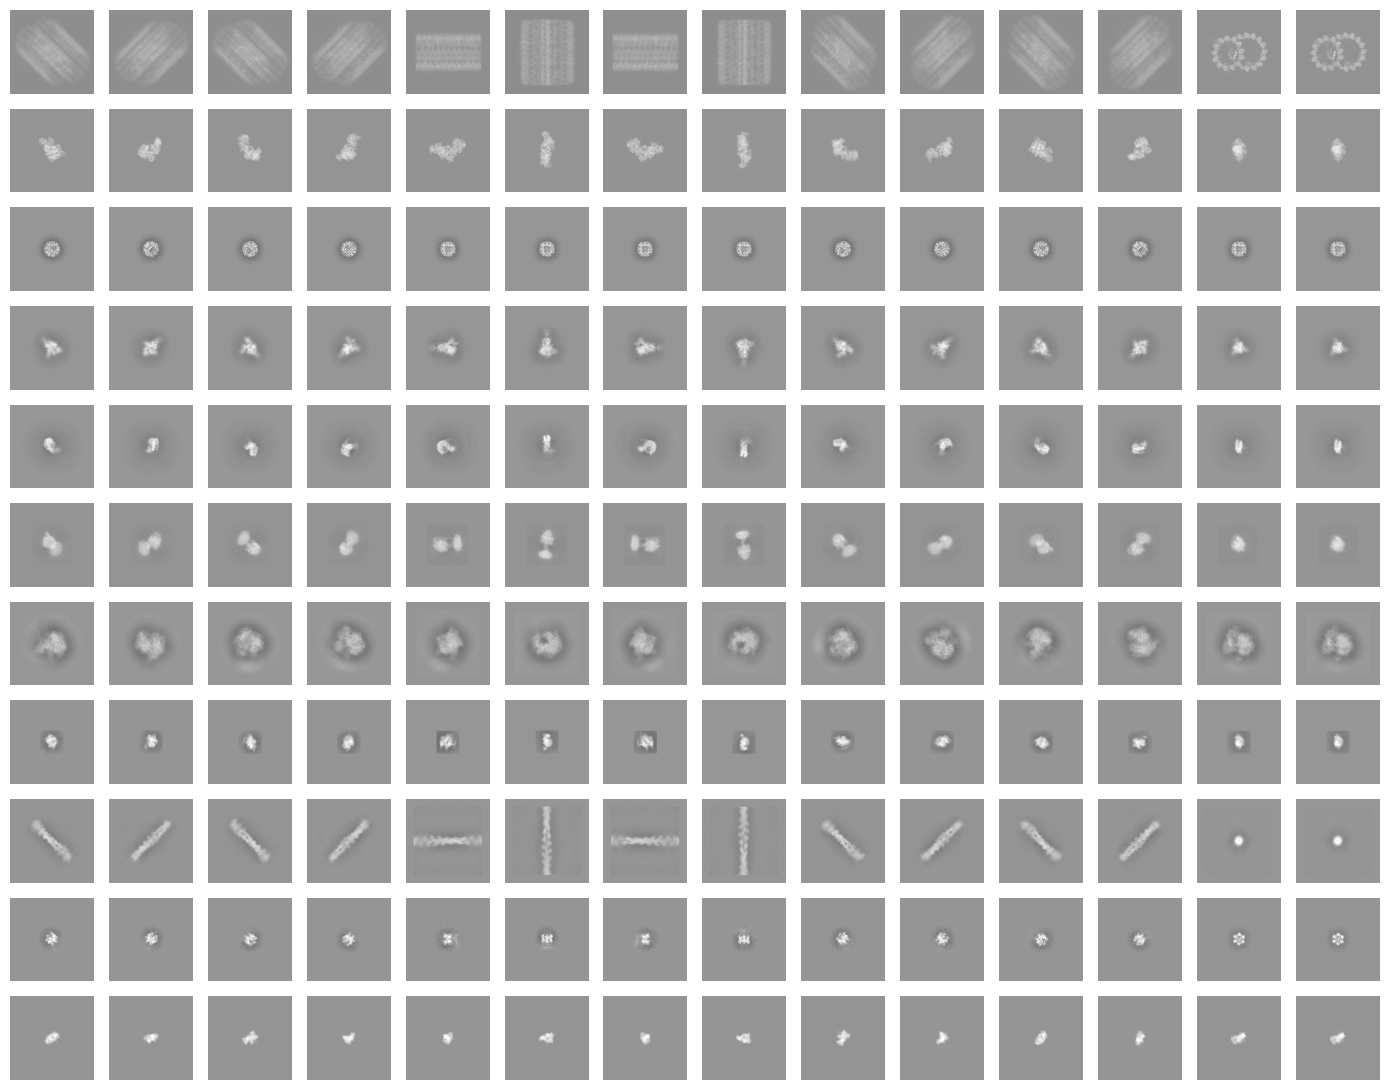

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

def plot_projections(imgs, labels=None, max_imgs=1000, nrows=2):
    if len(imgs) > max_imgs:
        imgs = imgs[:max_imgs]

    N = len(imgs)
    ncols = N // nrows

    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(ncols, nrows)
    )

    if not isinstance(axes, np.ndarray):
        axes = np.array([[axes]])
    if labels is None:
        labels = [None for _ in axes.ravel()]

    for img, ax, lbl in zip(imgs, axes.ravel(), labels):
        ax.imshow(img, vmin=-15, vmax=15,cmap="Greys_r")
        if lbl is not None:
            ax.set_title(lbl)
        ax.axis("off")

    plt.tight_layout()
    return fig, axes


plot_projections(imglist.view([-1,128,128]), nrows=11)
plt.show()

In [61]:
# analyze data from the big run

emds = [x[:-1].lower().replace('-','_') for x in open("../val2025_maps.txt",'r').readlines()]
results = []
for i,e in enumerate(emds):
    if os.path.exists('/home/gridsan/jroney/val_2025_dataset/' + e + "_search_res.pt"):
        results.append(torch.load('/home/gridsan/jroney/val_2025_dataset/' + e + "_search_res.pt", map_location='cpu'))

corr_all = torch.stack([r['corr'] for r in results])
top_indices = corr_all.topk(64, dim=-1)[1] // 192 # the map id that each query projection hits to


def score_hits(topics, indices, terms):
    res = torch.zeros(indices.shape)
    # assumes first dim is different queries, last is hit ranking

    for i, (ts, ind) in enumerate(zip(terms, indices)):
        ind = ind.view((-1,))
        hit_topics = [topics[j][1].lower() for j in ind]
        correct = [any([all([a in ht for a in t.split(";")]) for t in ts]) for ht in hit_topics]
        res[i] = torch.tensor(correct, dtype=torch.float).view(res[i].shape)
    return res

search_terms = [["doublet", "microtubule"],
                ["complex i"],
                ["apoferritin"],
                ["spike", "sars-cov-2"],
                ["nucleosome"],
                ["fof1", "atp synthase"],
                ["70s"], 
                ["cas9", "spcas9"],
                ["actin"],
                ["hiv;capsid", "hiv;hexamer"],
                ["cdc37", "hsp90"]]

all_topics = sorted(pickle.load(open("../emdb_topics.pkl", 'rb')), key=lambda x:x[0])

hit_acc = score_hits(all_topics, top_indices, search_terms)




/tmp/ipykernel_107098/2712739033.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results.append(torch.load('/home/gridsan/jroney/val_2025_dataset/' + e + "_search_res.pt

In [95]:
order[1].shape

torch.Size([11, 14])

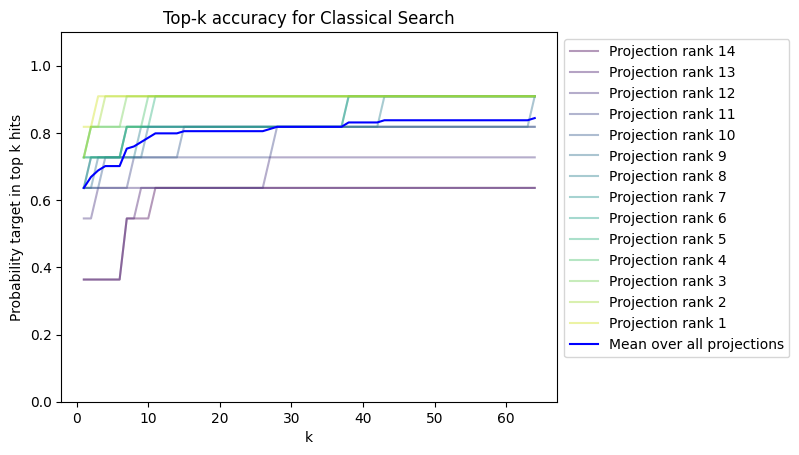

In [111]:
cum_acc = (hit_acc.cumsum(dim=-1) > 0).to(torch.float)

import matplotlib.pyplot as plt
import matplotlib.cm as cm

aucs = cum_acc.sum(dim=-1)
order = aucs.sort(dim=-1)

for i in range(14):
    plt.plot(torch.arange(cum_acc.shape[-1]) + 1, cum_acc[torch.arange(11),order[1][:,i]].mean(dim=0), alpha=0.4, c=cm.viridis(i/14), label=f"Projection rank {14-i}")

plt.plot(torch.arange(cum_acc.shape[-1]) + 1, cum_acc.mean(dim=(0,1)), color="blue", label="Mean over all projections")


plt.xlabel("k")
plt.ylabel("Probability target in top k hits")
plt.title("Top-k accuracy for Classical Search")
plt.legend(bbox_to_anchor=(1, 1))
plt.ylim(0,1.1)
plt.show()

In [118]:
import torch.nn.functional as F
with torch.no_grad():
    query_embs = F.normalize(model(imglist.view([-1,1,128,128]).cuda()), p=2, dim=-1)

In [120]:
import time
s = time.time()
affinities = (query_embs @ all_embs.t()).cpu()
e = time.time()

print(e-s)

0.15201997756958008


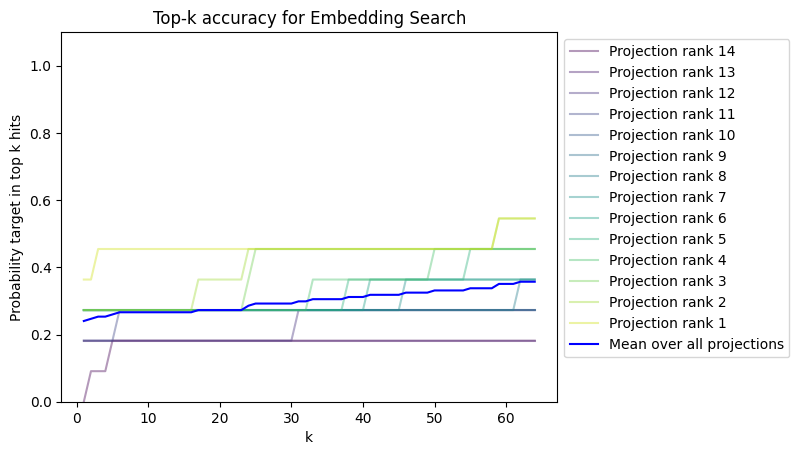

In [126]:
top_affinities, top_indices = torch.topk(affinities, k=64, dim=1)
top_indices = top_indices.view([11,14,-1]) // 192

hit_acc = score_hits(all_topics, top_indices, search_terms)
cum_acc = (hit_acc.cumsum(dim=-1) > 0).to(torch.float)

import matplotlib.pyplot as plt
import matplotlib.cm as cm

aucs = cum_acc.sum(dim=-1)
order = aucs.sort(dim=-1)

for i in range(14):
    plt.plot(torch.arange(cum_acc.shape[-1]) + 1, cum_acc[torch.arange(11),order[1][:,i]].mean(dim=0), alpha=0.4, c=cm.viridis(i/14), label=f"Projection rank {14-i}")

plt.plot(torch.arange(cum_acc.shape[-1]) + 1, cum_acc.mean(dim=(0,1)), color="blue", label="Mean over all projections")


plt.xlabel("k")
plt.ylabel("Probability target in top k hits")
plt.title("Top-k accuracy for Embedding Search")
plt.legend(bbox_to_anchor=(1, 1))
plt.ylim(0,1.1)
plt.show()

(<Figure size 1100x200 with 22 Axes>,
 array([[<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >]], dtype=object))

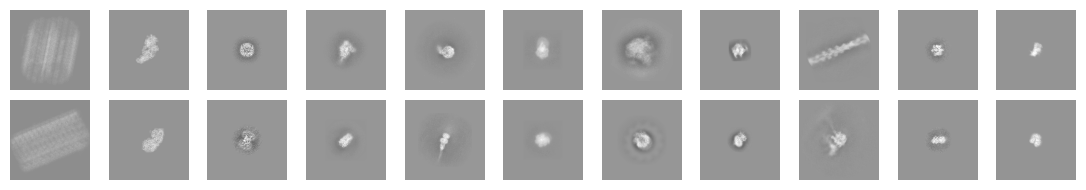

In [35]:
%matplotlib inline

import matplotlib.pyplot as plt

i = 10
plot_projections(torch.stack([query_imgs[:,0], images_all[top_indices[:,0]]], dim=0).view([-1,128,128]))

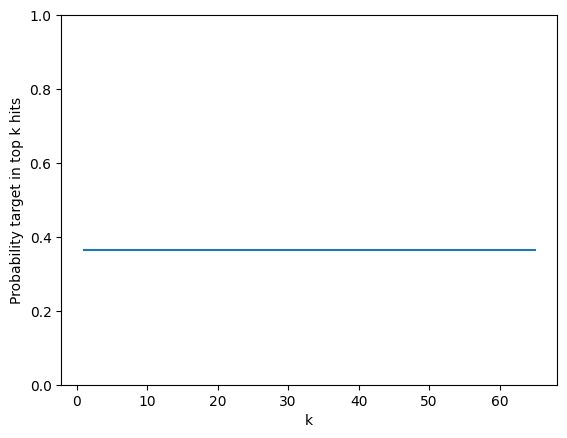

In [36]:
search_terms = [["doublet", "microtubule"],
                ["complex i"],
                ["apoferritin"],
                ["spike", "sars-cov-2"],
                ["nucleosome"],
                ["fof1", "atp synthase"],
                ["70s"], 
                ["cas9", "spcas9"],
                ["actin"],
                ["hiv", "capsid"],
                ["cdc37", "hsp90"]]

all_topics = sorted(pickle.load(open("../emdb_topics.pkl", 'rb')), key=lambda x:x[0])

top_hits_emb = [[all_topics[i] for i in r] for r in  top_indices // 192]
hit_rate_emb = [[any([s in h[1].lower() for s in ss]) for h in th] for ss,th in zip(search_terms, top_hits_emb)]    

import matplotlib.pyplot as plt
hr = torch.tensor(hit_rate_emb, dtype=torch.float)
plt.plot(torch.arange(hr.shape[-1]) + 1, (hr.cumsum(dim=-1) > 0).float().mean(dim=0))
plt.xlabel("k")
plt.ylabel("Probability target in top k hits")
plt.ylim(0,1)
plt.show()

In [37]:
# now try classical search

from proj_search import optimize_theta_trans_chunked

from cryodrgn import shift_grid, so3_grid
trans = torch.tensor(shift_grid.base_shift_grid(0, 7, 7, xshift=0, yshift=0))
angles = torch.tensor(so3_grid.grid_s1(2), dtype=torch.float)
query_imgs_raw = imglist_raw[query_idxs]

best_corr, best_indices, corr = optimize_theta_trans_chunked((images_all_raw - images_all_raw.mean(dim=(-1,-2), keepdim=True)).view([-1,128,128]), (query_imgs_raw - query_imgs_raw.mean(dim=(-1,-2), keepdim=True)).cuda(), trans.cuda(), angles, chunk_size=30, fast_translate=False, fast_rotate=True, refine_fast_translate=False)

(INFO) (lattice.py) (10-Mar-25 23:09:19) Using circular lattice with radius=64


In [38]:
ids_all[best_indices[:,0].cpu()]

tensor([35810, 15071, 29575, 25711, 29853, 33283, 15672, 14497, 26463, 33396,
        14532])

(<Figure size 1100x200 with 22 Axes>,
 array([[<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >]], dtype=object))

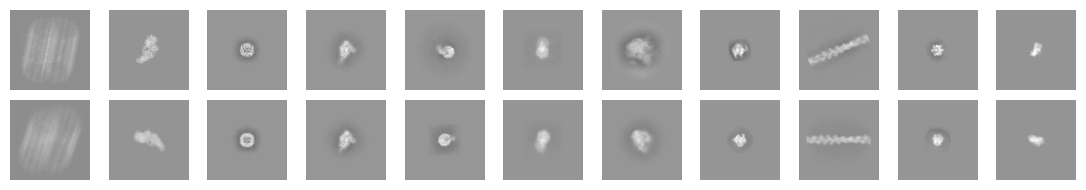

In [39]:
%matplotlib inline

flat = images_all.view([-1,128,128])

plot_projections(torch.stack([query_imgs[:,0], flat[best_indices[:,0].cpu()]]).view([-1,128,128]))

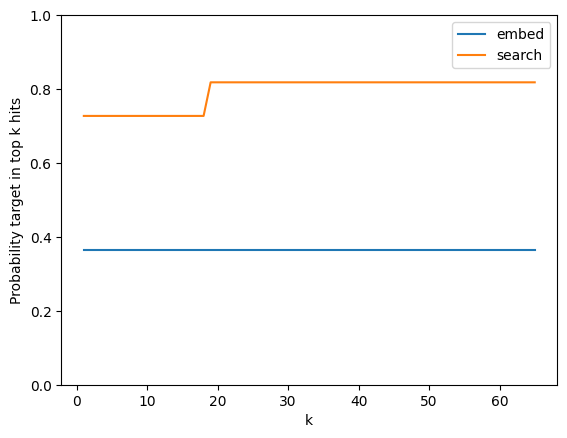

In [46]:
top_hits_search = [[all_topics[i] for i in r] for r in  corr.topk(65,dim=-1)[1] // 192]
hit_rate_search = [[any([s in h[1].lower() for s in ss]) for h in th] for ss,th in zip(search_terms, top_hits_search)]    

import matplotlib.pyplot as plt
hr = torch.tensor(hit_rate_search, dtype=torch.float)
hr_e = torch.tensor(hit_rate_emb, dtype=torch.float)

plt.plot(torch.arange(hr.shape[-1]) + 1, (hr_e.cumsum(dim=-1) > 0).float().mean(dim=0), label="embed")
plt.plot(torch.arange(hr.shape[-1]) + 1, (hr.cumsum(dim=-1) > 0).float().mean(dim=0), label="search")
plt.xlabel("k")
plt.ylabel("Probability target in top k hits")
plt.ylim(0,1)
plt.legend()
plt.show()

In [65]:
top_hits_search[6]

[(3320, '```json\n[\n  "Human BIRC6",\n  "HTRA2"\n]\n```'),
 (3320, '```json\n[\n  "Human BIRC6",\n  "HTRA2"\n]\n```'),
 (3320, '```json\n[\n  "Human BIRC6",\n  "HTRA2"\n]\n```'),
 (3320, '```json\n[\n  "Human BIRC6",\n  "HTRA2"\n]\n```'),
 (3320, '```json\n[\n  "Human BIRC6",\n  "HTRA2"\n]\n```'),
 (3320, '```json\n[\n  "Human BIRC6",\n  "HTRA2"\n]\n```'),
 (1240, '- SAGA transcriptional coactivator complex\n- human SAGA complex\n'),
 (3122, "['60S Ytm1', '60S class 3']\n"),
 (3320, '```json\n[\n  "Human BIRC6",\n  "HTRA2"\n]\n```'),
 (104, "['PBAF complex']\n"),
 (3320, '```json\n[\n  "Human BIRC6",\n  "HTRA2"\n]\n```'),
 (1240, '- SAGA transcriptional coactivator complex\n- human SAGA complex\n'),
 (3320, '```json\n[\n  "Human BIRC6",\n  "HTRA2"\n]\n```'),
 (3122, "['60S Ytm1', '60S class 3']\n"),
 (3320, '```json\n[\n  "Human BIRC6",\n  "HTRA2"\n]\n```'),
 (3199, '```json\n[\n  "Human BIRC6",\n  "SMAC"\n]\n```'),
 (3122, "['60S Ytm1', '60S class 3']\n"),
 (3320, '```json\n[\n  "Hum